In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [2]:
def gpu_setup():
    """Setup the available GPUs to be used for training."""
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # Specify GPU to restrict usage below
        tf.config.set_visible_devices([physical_devices[2], physical_devices[3]], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        # Logical device was not created for first GPU
        assert len(logical_devices) == len(physical_devices) - 1
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass


def mixed_precision_setup():
    """Setup support for mixed precision training."""
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)

gpu_setup()
mixed_precision_setup()

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  Tesla V100S-PCIE-32GB, compute capability 7.0
  Tesla V100-PCIE-32GB, compute capability 7.0
  Tesla P100-PCIE-16GB, compute capability 6.0 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Data

In [3]:
seed = 0
data_dir = 'data'
image_shape = (512, 384, 3)

batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=seed,
    image_size=image_shape[:-1],
    batch_size=batch_size
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=image_shape[:-1],
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 2527 files belonging to 6 classes.
Using 2275 files for training.
Found 2527 files belonging to 6 classes.
Using 252 files for validation.
6 classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))).cache().prefetch(buffer_size=AUTOTUNE)

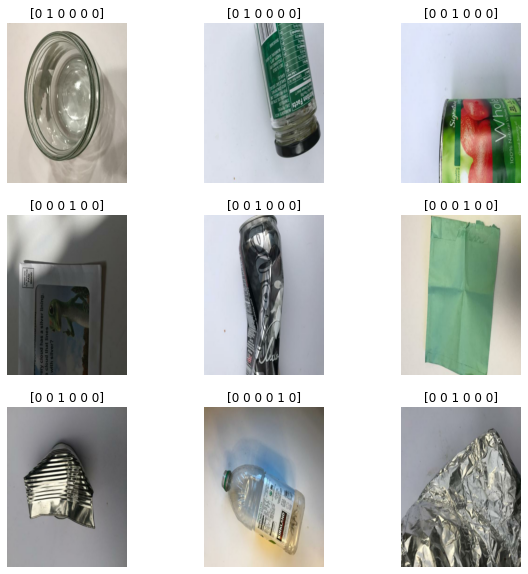

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype("uint8"))
        plt.axis("off")

# Model

In [6]:
import kerastuner as kt


class HyperRecycleNet(kt.HyperModel):
    def __init__(self, input_shape, num_classes):
        self.num_classes = num_classes
        self.input_shape = input_shape

    def build(self, hp):
        model = self.define_model(hp)
        model = self.compile(model, hp)
        return model
    
    def fine_tune(self, model, hp):
        model = self.define_fine_tune_model(model, hp)
        model = self.compile(model, hp, fine_tune=True)
        return model
    
    def define_model(self, hp):
        """Defines a pretrained MobileNetV2 model."""
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = False
        prediction_layer = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(hp['dropout']),
            tf.keras.layers.Dense(self.num_classes, name='logits'),
            tf.keras.layers.Activation('softmax', dtype='float32', name='probs'), # separate actf to support mixed precision
        ], name='prediction')

        inputs = tf.keras.Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs)
        return model
    
    def define_fine_tune_model(self, model, hp):
        """Defines a model with more trainable parameters."""
        model.layers[1].trainable = True
        num_layers = len(model.layers[1].layers)
        freeze_til = num_layers - hp['num_unfreeze_layers']
        for layer in model.layers[1].layers[:freeze_til]:
            layer.trainable = False
        return model
    
    def compile(self, model, hp, fine_tune=False):
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=hp['learning_rate'] if not fine_tune else hp['fine_learning_rate'] 
            ),
            loss=tf.keras.losses.CategoricalCrossentropy(
                label_smoothing=0.1
            ),
            metrics=['accuracy']
        )
        return model


class FineTuner(kt.Tuner):
    def run_trial(self, trial, train_ds, valid_ds):
        model = self.hypermodel.build(trial.hyperparameters)
        history = model.fit(
            train_ds, 
            validation_data=valid_ds,
            initial_epoch=0,
            epochs=trial.hyperparameters['num_epochs']
        )
        
        model = self.hypermodel.hypermodel.fine_tune(model, trial.hyperparameters) # bypass kerashypermodel to actual hypermodel that was defined 
        history = model.fit(
            train_ds, 
            validation_data=valid_ds,
            initial_epoch=trial.hyperparameters['num_epochs'],
            epochs=trial.hyperparameters['num_epochs'] + trial.hyperparameters['fine_num_epochs']
        )
        
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': history.history['val_accuracy'][-1]})
        self.save_model(trial.trial_id, model)

hp = kt.HyperParameters()
hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
hp.Int('num_epochs', min_value=50, max_value=300)
hp.Float('fine_learning_rate', min_value=1e-7, max_value=1e-5, sampling='log')
hp.Int('fine_num_epochs', min_value=10, max_value=100)
hp.Float('dropout', min_value=0., max_value=0.8)
hp.Int('num_unfreeze_layers', min_value=0, max_value=100)

hypermodel = HyperRecycleNet(input_shape=(512, 384, 3), num_classes=6)

In [7]:
# tuner = kt.Hyperband(
#     hypermodel,
#     hyperparameters=hp,
#     tune_new_entries=True,
#     objective='val_accuracy',
#     max_epochs=10,
#     directory='my_dir',
#     project_name='helloworld'
# )

# tuner.search(
#     train_ds,
#     validation_data=valid_ds,
#     epochs=1,
# )

In [8]:
tuner = FineTuner(
    hypermodel=hypermodel,
    oracle=kt.oracles.BayesianOptimization(
        objective='val_accuracy',
        max_trials=10,
        hyperparameters=hp,
    ),
    directory='my_dir',
    project_name='helloworld'
)

tuner.search(train_ds, valid_ds)

INFO:tensorflow:Reloading Oracle from existing project my_dir/helloworld/oracle.json
Traceback (most recent call last):
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 10, in build
    model = self.define_model(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 36, in define_model
    outputs = prediction_layer(x)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 926, in __call__
    input_list)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1117, in _functional_construction_call
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py", line 386, in call
    outputs = layer(inputs, **kwargs)
  File "/home

Traceback (most recent call last):
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 10, in build
    model = self.define_model(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 36, in define_model
    outputs = prediction_layer(x)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 926, in __call__
    input_list)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1117, in _functional_construction_call
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py", line 386, in call
    outputs = layer(inputs, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base

Traceback (most recent call last):
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 10, in build
    model = self.define_model(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 36, in define_model
    outputs = prediction_layer(x)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 926, in __call__
    input_list)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1117, in _functional_construction_call
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py", line 386, in call
    outputs = layer(inputs, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base

Traceback (most recent call last):
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 10, in build
    model = self.define_model(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 36, in define_model
    outputs = prediction_layer(x)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 926, in __call__
    input_list)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1117, in _functional_construction_call
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py", line 386, in call
    outputs = layer(inputs, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base

Traceback (most recent call last):
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 10, in build
    model = self.define_model(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 36, in define_model
    outputs = prediction_layer(x)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 926, in __call__
    input_list)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1117, in _functional_construction_call
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py", line 386, in call
    outputs = layer(inputs, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base

Traceback (most recent call last):
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 10, in build
    model = self.define_model(hp)
  File "<ipython-input-6-d5d8d3bd4c70>", line 36, in define_model
    outputs = prediction_layer(x)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 926, in __call__
    input_list)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1117, in _functional_construction_call
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py", line 386, in call
    outputs = layer(inputs, **kwargs)
  File "/home/zongsien/recycle/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/base

RuntimeError: Too many failed attempts to build model.

In [9]:
  best_hps = tuner.get_best_hyperparameters()[0]
  print(best_hps.values)

  best_model = tuner.get_best_models()[0]

{'learning_rate': 0.001, 'num_epochs': 1, 'fine_learning_rate': 1e-05, 'fine_num_epochs': 1, 'dropout': 0.2, 'num_unfreeze_layers': 10}


In [10]:
save_path = os.path.join('model', 'mobilenetv2', '1', 'saved_model') # model name, version
tf.saved_model.save(best_model, save_path)